# Synthetic data test: Model with multiple sources and moving window scheme

In [1]:
import numpy as np
import harmonica as hm
import verde as vd
import matplotlib.pyplot as plt
import xrft
import euler

Number of data: 22701


/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


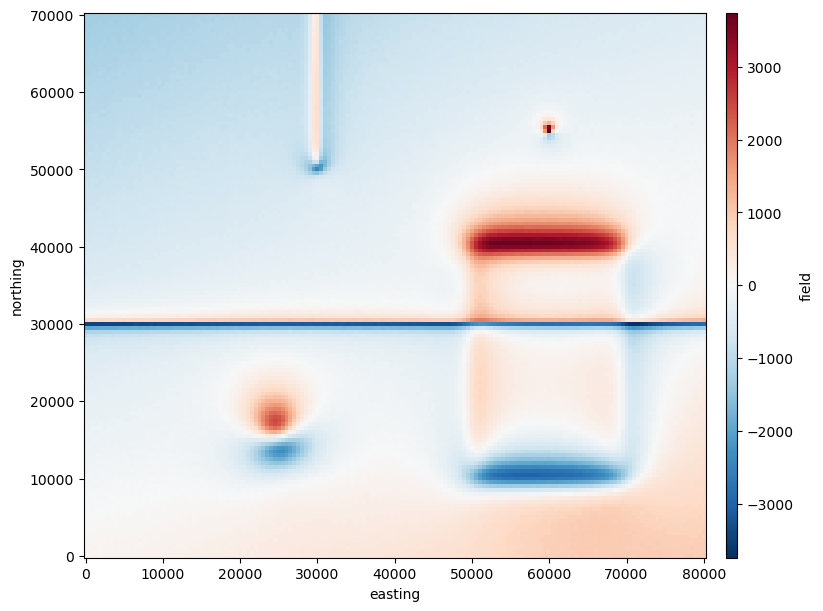

In [2]:
region = [0, 80e3, 0, 70e3]
coordinates = vd.grid_coordinates(region, spacing=500, extra_coords=1000)
inclination, declination = -30, -10
base_level = 100
main_field = hm.magnetic_angles_to_vec(1, inclination, declination)

# Dipole
dipole_coordinates = (25e3, 15e3, -3e3)
magnetic_field = hm.dipole_magnetic(
    coordinates, 
    dipoles=dipole_coordinates,
    magnetic_moments=hm.magnetic_angles_to_vec(2e12, inclination, declination),
    field="b",
)
magnetic_anomaly = sum(b * f for b, f in zip(magnetic_field, main_field))

# Pipe
size = 50
pipe_coordinates = (60e3, 55e3, 500)
magnetic_field = hm.prism_magnetic(
    coordinates, 
    prisms=[
        pipe_coordinates[0] - size, 
        pipe_coordinates[0] + size, 
        pipe_coordinates[1] - size, 
        pipe_coordinates[1] + size, 
        pipe_coordinates[2] - 15e3, 
        pipe_coordinates[2], 
    ],
    magnetization=hm.magnetic_angles_to_vec(2000, -90, 0),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

# Dike
dike_coordinates = (50e3, 30e3, 900)
magnetic_field = hm.prism_magnetic(
    coordinates, 
    prisms=[
        dike_coordinates[0] - 100e3, 
        dike_coordinates[0] + 100e3, 
        dike_coordinates[1] - 100, 
        dike_coordinates[1] + 100, 
        dike_coordinates[2] - 7e3, 
        dike_coordinates[2], 
    ],
    magnetization=hm.magnetic_angles_to_vec(20, inclination, declination),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

# Line
line_coordinates = [30e3, 50e3, 0]
magnetic_field = hm.prism_magnetic(
    coordinates, 
    prisms=[
        line_coordinates[0] - 50, 
        line_coordinates[0] + 50, 
        line_coordinates[1], 
        line_coordinates[1] + 100e3, 
        line_coordinates[2] - 50, 
        line_coordinates[2] + 50, 
    ],
    magnetization=hm.magnetic_angles_to_vec(3000, inclination, declination),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

# Sill
sill_coordinates = [60e3, 25e3, -1e3]
magnetic_field = hm.prism_magnetic(
    coordinates, 
    prisms=[
        sill_coordinates[0] - 10e3, 
        sill_coordinates[0] + 10e3, 
        sill_coordinates[1] - 15e3, 
        sill_coordinates[1] + 15e3, 
        sill_coordinates[2] - 100, 
        sill_coordinates[2] + 100, 
    ],
    magnetization=hm.magnetic_angles_to_vec(200, inclination, declination),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

# Regional
magnetic_anomaly += 0.01 * coordinates[0] - 0.02 * coordinates[1]

# Add noise and the base level
magnetic_anomaly += np.random.default_rng(42).normal(0, 10, size=magnetic_anomaly.shape)
magnetic_anomaly += base_level

print(f"Number of data: {magnetic_anomaly.size}")

# Make a grid and calculate derivatives
# Can't have the height as a coordinate because of a problem with xrft
data = vd.make_xarray_grid(coordinates[:2], (magnetic_anomaly, coordinates[-1]), data_names=["field", "height"])
data["deriv_east"] = hm.derivative_easting(data.field)
data["deriv_north"] = hm.derivative_northing(data.field)
pad_width = {
    "easting": data.easting.size // 3,
    "northing": data.northing.size // 3,
}
padded = xrft.pad(data.field, pad_width, mode="linear_ramp", constant_values=None)
data["deriv_up"] = xrft.unpad(hm.derivative_upward(padded), pad_width)
# Add back the height
data = data.assign_coords(height=data.height)

fig, ax = plt.subplots(1, 1, figsize=(10, 6), layout='constrained')
data.field.plot.pcolormesh(ax=ax, cbar_kwargs=dict(orientation="vertical", aspect=50, pad=0))
ax.set_aspect("equal")
plt.show()

In [3]:
ed = euler.EulerDeconvolutionWindowed(structural_index=3, window_size=10e3, window_step=5e3)
ed.fit_grid(data)

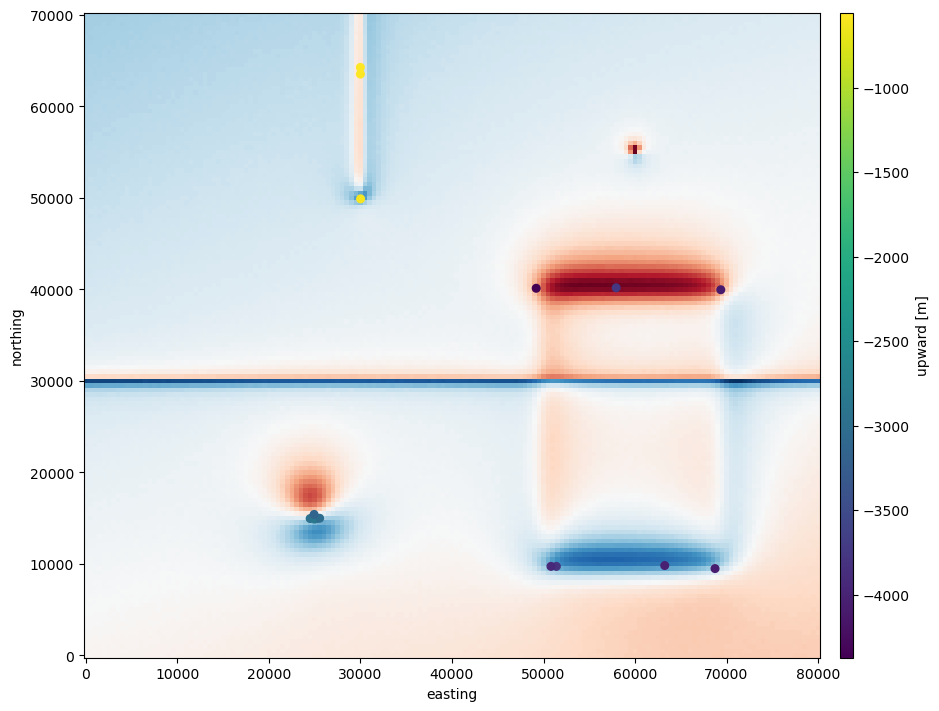

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7), layout='constrained')
data.field.plot.pcolormesh(ax=ax, add_colorbar=False)
tmp = ax.scatter(*ed.locations_[:2], c=ed.locations_[2], s=30)
fig.colorbar(tmp, aspect=50, pad=0, label="upward [m]")
ax.set_aspect("equal")

In [5]:
%%time
ei = euler.EulerInversionWindowed(window_size=10e3, window_step=5e3, max_variance=0.3)
ei.fit_grid(data)

Output()

CPU times: user 5.29 s, sys: 509 ms, total: 5.79 s
Wall time: 1min 21s


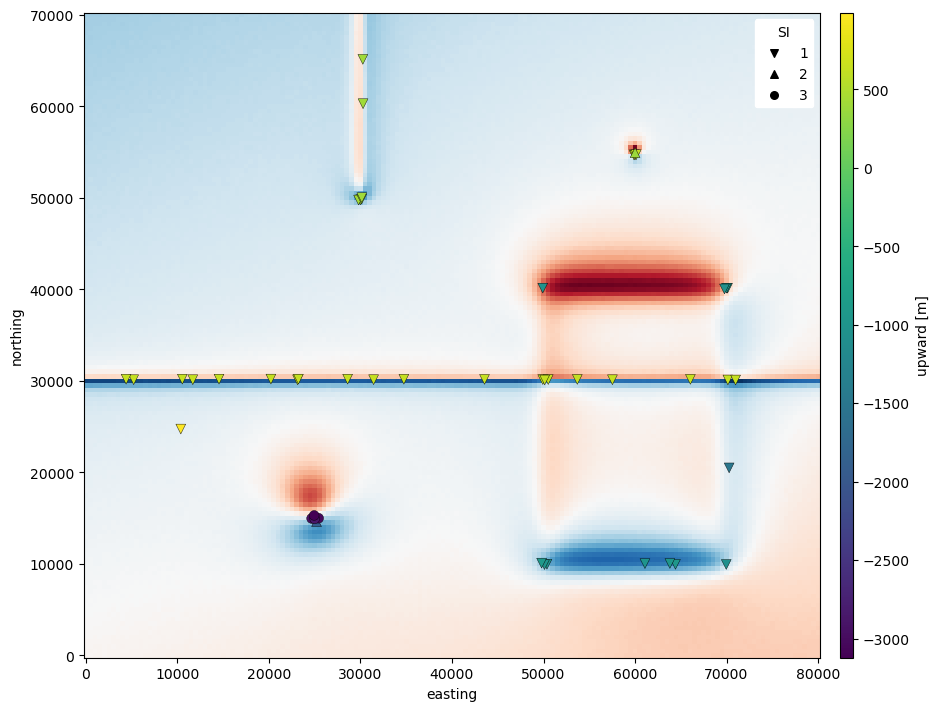

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7), layout='constrained')
ax.set_aspect("equal")
data.field.plot.pcolormesh(ax=ax, add_colorbar=False)
labels = {}
markers = ["v", "^", "o"]
vmin, vmax = ei.locations_[2].min(), ei.locations_[2].max()
for si, marker in zip([1, 2, 3], markers):
    is_si = ei.structural_indices_ == si
    tmp = ax.scatter(
        *ei.locations_[:2, is_si], 
        c=ei.locations_[2, is_si], 
        s=50, 
        marker=marker, 
        vmin=vmin, 
        vmax=vmax, 
        edgecolors="black", 
        linewidths=0.3,
    )
    labels[si] = ax.scatter([] , [], c="black", s=30, marker=marker)
ax.legend(
    [labels[si] for si in sorted(labels)],
    sorted(labels),
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
    title="SI",
)
fig.colorbar(tmp, aspect=50, pad=0, label="upward [m]")